# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Akhil\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above students 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:50<00:00, 1579.41it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [24]:
ln = (len(preprocessed_reviews))

In [25]:
final['preprocessed_text']=preprocessed_reviews

In [26]:
#calculating the number of words in each review
length = []
for i in range(len(preprocessed_reviews)):
    length.append(len(preprocessed_reviews[i].split()))
final['length_of_text']=length

### Preparing datasets

In [27]:
#splitting data evenly to avoid imbalance data

positive_data = final[final["Score"] == 1].sample(n = 50000)
negative_data = final[final["Score"] == 0].sample(n = 50000)
new_final = pd.concat([positive_data, negative_data])
new_final.shape

(100000, 12)

In [28]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
#conversion of Unix time
new_final["Time"] = pd.to_datetime(new_final["Time"], unit = "s")
new_final = new_final.sort_values(by = "Time")

In [29]:
new_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text,length_of_text
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,21
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...,11
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...,32
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...,31
138017,149789,B00004S1C6,A1KXONFPU2XQ5K,Stephanie Manley,26,28,1,2000-08-09,A must have!,"These are easy to use, they do not make a mess...",easy use not make mess offer vibrant colors no...,18


In [30]:
#converting the dataframe to array
# x contains all reviews
# y contains its corresponding class labels
x = new_final['preprocessed_text'].values
y = new_final['Score'].values
print(y.shape)
print(type(y))
print(x.shape)
print(type(x))


(100000,)
<class 'numpy.ndarray'>
(100000,)
<class 'numpy.ndarray'>


### Splitting Data

In [31]:
# Splitting x and y (total data) for x1,y1 and xTest, yTest
x1 = x[:75000]
y1 = y[:75000]
xTest = x[75000:]
yTest = y[75000:]

# Splitting x1 and y2 for xCV,yCV and xTrain, yTrain
xTrain = x1[:56250]
yTrain = y1[:56250]
xCV = x1[56250:]
yCV = y1[56250:]

In [32]:

print("Shape of Train data "+ str(xTrain.shape), str(yTrain.shape))
print("Shape of Test data "+ str(xTest.shape), str(yTest.shape))
print("Shape of Cross Validation data "+ str(xCV.shape), str(yCV.shape))

Shape of Train data (56250,) (56250,)
Shape of Test data (25000,) (25000,)
Shape of Cross Validation data (18750,) (18750,)


In [33]:
#from sklearn.model_selection import train_test_split

# Splitting Train and Test data from total data
#xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25)

# Splitting Train and Cross Validate data from Train data
#xTrain, xCV, yTrain, yCV = train_test_split(xTrain, yTrain, test_size = 0.25)

#print("Shape of Train data "+ str(xTrain.shape), str(yTrain.shape))
#print("Shape of Test data "+ str(xTest.shape), str(yTest.shape))
#print("Shape of Cross Validation data "+ str(xCV.shape), str(yCV.shape))


In [34]:
# frequency count of number of positive and negative values in Train data
# source: https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-94.php
print(type(yTrain))
unique_elements, counts_elements = np.unique(yTrain, return_counts=True)
print("Number of positive and negative values in Train data")
print(np.asarray((unique_elements, counts_elements)))

<class 'numpy.ndarray'>
Number of positive and negative values in Train data
[[    0     1]
 [26732 29518]]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Linear SVM

### 1. Bag of Words Vectorization

In [35]:
#Bag of Words

count_vect = CountVectorizer()
count_vect.fit(xTrain)
xTrain_bow=count_vect.transform(xTrain)
xCV_bow=count_vect.transform(xCV)
xTest_bow=count_vect.transform(xTest)
print("After transform")
print('='*100)
print("Train Data")
print(xTrain_bow.shape, yTrain.shape)
print("Cross Validation Data")
print(xCV_bow.shape, yCV.shape)
print("Test Data")
print(xTest_bow.shape, yTest.shape)
print('='*100)

After transform
Train Data
(56250, 46244) (56250,)
Cross Validation Data
(18750, 46244) (18750,)
Test Data
(25000, 46244) (25000,)


### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font> L1 Reg


In [36]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
AUC_BOW_Train = []
AUC_BOW_CV = []

# Linear SVM on alpha values - L1 reg
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l1', alpha = i, class_weight = 'balanced')
    clf.fit(xTrain_bow, yTrain)
    calib = CalibratedClassifierCV(clf, method="sigmoid")
    calib.fit(xTrain_bow, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value
    Y_train_pred =  calib.predict_proba(xTrain_bow)[:,1]
    Y_cv_pred =  calib.predict_proba(xCV_bow)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data
    AUC_BOW_Train.append(roc_auc_score(yTrain,Y_train_pred))
    AUC_BOW_CV.append(roc_auc_score(yCV, Y_cv_pred))



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00,  3.52s/it]


In [37]:
print(AUC_BOW_Train)

[0.9803061590674094, 0.9600406951593166, 0.9253742237862519, 0.8336758701936404, 0.6927052435875896, 0.5, 0.5, 0.5, 0.5]


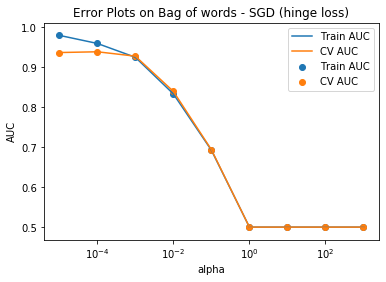

In [38]:
#plotting error plots
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

plt.plot(alpha_values, AUC_BOW_Train, label='Train AUC')
plt.plot(alpha_values, AUC_BOW_CV, label='CV AUC')

plt.scatter(alpha_values, AUC_BOW_Train, label='Train AUC')
plt.scatter(alpha_values, AUC_BOW_CV, label='CV AUC')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("Error Plots on Bag of words - SGD (hinge loss)")
plt.show()

In [39]:
#SGDClassifier on test data with optimal alpha = 0.0001
optimal = SGDClassifier(loss = "hinge", penalty='l1', alpha = 0.0001, class_weight = 'balanced')
optimal.fit(xTrain_bow, yTrain)
calib1 = CalibratedClassifierCV(optimal, method="sigmoid")
calib1.fit(xTrain_bow, yTrain)
predict_BOW_prob = calib1.predict_proba(xTest_bow)[:,1]
Train_predict_BOW = calib1.predict_proba(xTrain_bow)[:,1]
predict_BOW_class = calib1.predict(xTest_bow)
predict_testdata_BOW = calib1.predict(xTrain_bow)

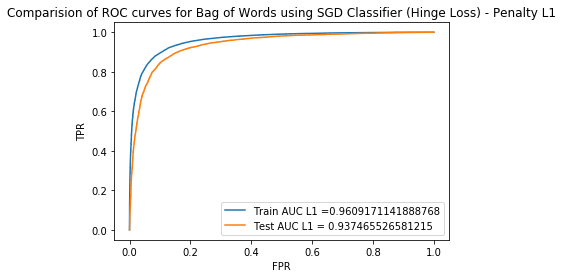

In [40]:
from sklearn.metrics import roc_curve, auc
Tr_FPR, Tr_TPR, tr = roc_curve(yTrain, Train_predict_BOW)
Te_FPR, Te_TPR, te = roc_curve(yTest, predict_BOW_prob)

plt.plot(Tr_FPR, Tr_TPR, label="Train AUC L1 ="+str(auc(Tr_FPR, Tr_TPR)))
plt.plot(Te_FPR, Te_TPR, label="Test AUC L1 = "+str(auc(Te_FPR, Te_TPR)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for Bag of Words using SGD Classifier (Hinge Loss) - Penalty L1")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

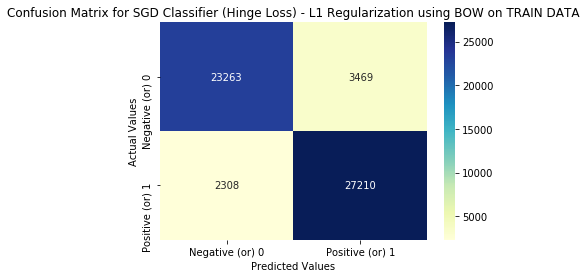

In [41]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_BOW)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for SGD Classifier (Hinge Loss) - L1 Regularization using BOW on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

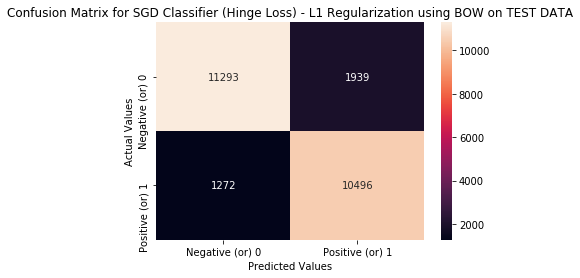

In [42]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_BOW_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for SGD Classifier (Hinge Loss) - L1 Regularization using BOW on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font> L2 Reg


In [43]:
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
AUC_BOW_Train_l2 = []
AUC_BOW_CV_l2 = []

# Linear SVM with L2 regularization on alpha values
for i in tqdm(alpha_values):
    clf_l2 = SGDClassifier(loss = "hinge", penalty='l2', alpha = i, class_weight = 'balanced')
    clf_l2.fit(xTrain_bow, yTrain)
    calib_l2 = CalibratedClassifierCV(clf_l2, method="sigmoid")
    calib_l2.fit(xTrain_bow, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value
    Y_train_pred_l2 =  calib_l2.predict_proba(xTrain_bow)[:,1]
    Y_cv_pred_l2 =  calib_l2.predict_proba(xCV_bow)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data
    AUC_BOW_Train_l2.append(roc_auc_score(yTrain,Y_train_pred_l2))
    AUC_BOW_CV_l2.append(roc_auc_score(yCV, Y_cv_pred_l2))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.23s/it]


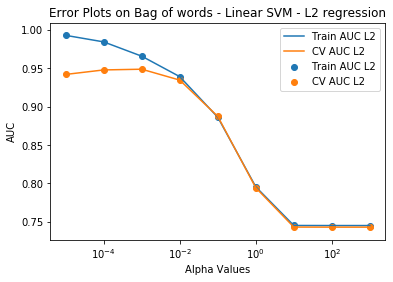

In [44]:
#error plots
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

plt.plot(alpha_values, AUC_BOW_Train_l2, label='Train AUC L2')
plt.plot(alpha_values, AUC_BOW_CV_l2, label='CV AUC L2')

plt.scatter(alpha_values, AUC_BOW_Train_l2, label='Train AUC L2')
plt.scatter(alpha_values, AUC_BOW_CV_l2, label='CV AUC L2')
plt.xscale('log')

plt.legend()
plt.xlabel("Alpha Values")
plt.ylabel("AUC")
plt.title("Error Plots on Bag of words - Linear SVM - L2 regression")
plt.show()

In [45]:
#Logistic Regression on test data with optimal alpha = 0.001
optimal_l2 = SGDClassifier(loss = "hinge", penalty='l2', alpha = 0.001, class_weight = 'balanced')
optimal_l2.fit(xTrain_bow, yTrain)
calib2 = CalibratedClassifierCV(optimal_l2, method="sigmoid")
calib2.fit(xTrain_bow, yTrain)
predict_BOW_prob = calib2.predict_proba(xTest_bow)[:,1]
Train_predict_BOW = calib2.predict_proba(xTrain_bow)[:,1]
predict_BOW_class = calib2.predict(xTest_bow)
predict_testdata_BOW2 = calib2.predict(xTrain_bow)


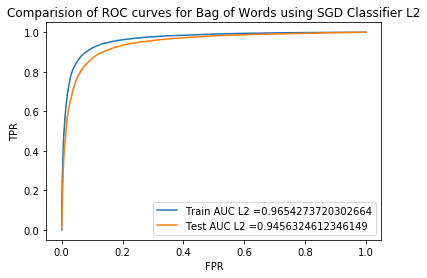

In [46]:
from sklearn.metrics import roc_curve, auc
Tr_FPR, Tr_TPR, tr = roc_curve(yTrain, Train_predict_BOW)
Te_FPR, Te_TPR, te = roc_curve(yTest, predict_BOW_prob)

plt.plot(Tr_FPR, Tr_TPR, label="Train AUC L2 ="+str(auc(Tr_FPR, Tr_TPR)))
plt.plot(Te_FPR, Te_TPR, label="Test AUC L2 ="+str(auc(Te_FPR, Te_TPR)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for Bag of Words using SGD Classifier L2")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

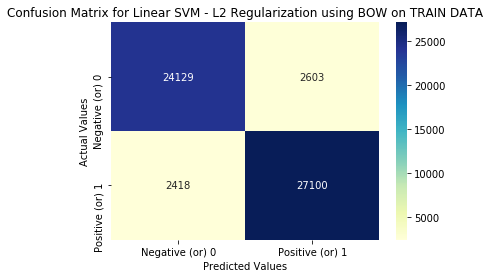

In [48]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_BOW2)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Linear SVM - L2 Regularization using BOW on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

Text(32.99999999999999, 0.5, 'Actual Values')

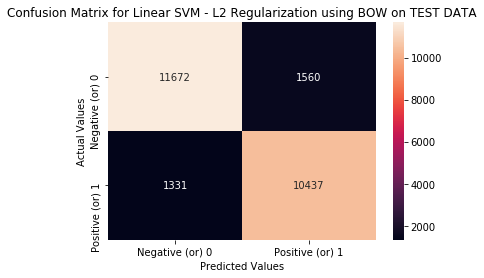

In [49]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_BOW_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Linear SVM - L2 Regularization using BOW on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


## Top 10 important features of Positive and Negative class - SET 1

In [50]:
#Source https://www.programcreek.com/python/example/81062/sklearn.datasets.load_iris

# calculating the weights obtained using the classifier
weights_l1_bow = optimal_l2.coef_

#pairing the weights and its corresponding features
wght_ftr_pair = dict()
feature_names = count_vect.get_feature_names()
for weight, feature in zip(weights_l1_bow[0], feature_names):
    wght_ftr_pair[weight] = feature

#printing the top 10 features
print("Top 10 positive features using Bag of Words")
print()
positive = sorted(zip(weights_l1_bow[0], feature_names))
print(positive[-10:])
print()
print('='*100)
print()
print("Top 10 negative features using Bag of Words")
print()
negative = sorted(zip(weights_l1_bow[0], feature_names))
print(negative[:10])

Top 10 positive features using Bag of Words

[(0.660990811931678, 'beat'), (0.6668179230304379, 'wonderful'), (0.6758798653886685, 'pleased'), (0.6904839554602147, 'best'), (0.6919937345573182, 'loves'), (0.6931798037846846, 'great'), (0.7142340830993071, 'highly'), (0.734371651275093, 'perfect'), (0.761022096637151, 'excellent'), (0.9005541882143108, 'delicious')]


Top 10 negative features using Bag of Words

[(-1.009363518921632, 'worst'), (-0.9696719806476221, 'disappointing'), (-0.8803674033341206, 'terrible'), (-0.8644840790807817, 'awful'), (-0.797401777508617, 'disappointed'), (-0.7401768215937198, 'horrible'), (-0.7363553245488195, 'bland'), (-0.7313288185147607, 'disappointment'), (-0.7239192369802778, 'unfortunately'), (-0.6299411401056425, 'sorry')]


##  Linear SVM on TFIDF<font color='red'> SET 2</font>

In [51]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(xTrain)
xTrain_tfidf=tf_idf_vect.transform(xTrain)
xCV_tfidf=tf_idf_vect.transform(xCV)
xTest_tfidf=tf_idf_vect.transform(xTest)
print("After transform")
print('='*100)
print(xTrain_tfidf.shape, yTrain.shape)
print(xCV_tfidf.shape, yCV.shape)
print(xTest_tfidf.shape, yTest.shape)

After transform
(56250, 33184) (56250,)
(18750, 33184) (18750,)
(25000, 33184) (25000,)


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font> L1 Reg

In [52]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
AUC_tfidf_Train = []
AUC_tfidf_CV = []


#Linear SVM with L1 regularization on alpha values
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l1', alpha = i, class_weight = 'balanced')
    clf.fit(xTrain_tfidf, yTrain)
    calib_l3 = CalibratedClassifierCV(clf, method="sigmoid")
    calib_l3.fit(xTrain_tfidf, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value
    Y_train_pred2 =  calib_l3.predict_proba(xTrain_tfidf)[:,1]
    Y_cv_pred2 =  calib_l3.predict_proba(xCV_tfidf)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data
    AUC_tfidf_Train.append(roc_auc_score(yTrain,Y_train_pred2))
    AUC_tfidf_CV.append(roc_auc_score(yCV, Y_cv_pred2))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.24s/it]


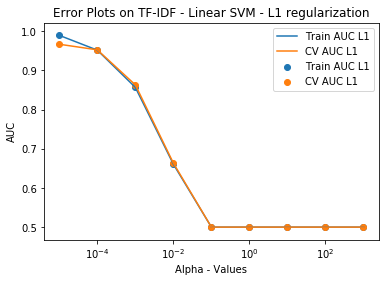

In [53]:
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(alpha_values, AUC_tfidf_Train, label='Train AUC L1')
plt.plot(alpha_values, AUC_tfidf_CV, label='CV AUC L1')

plt.scatter(alpha_values, AUC_tfidf_Train, label='Train AUC L1')
plt.scatter(alpha_values, AUC_tfidf_CV, label='CV AUC L1')
plt.xscale('log')

plt.legend()
plt.xlabel("Alpha - Values")
plt.ylabel("AUC")
plt.title("Error Plots on TF-IDF - Linear SVM - L1 regularization")
plt.show()

In [58]:
#Linear SVM on test data with optimal alpha = 0.00001
optimal_l1_tf = SGDClassifier(loss = "hinge", penalty='l1', alpha = 0.00001, class_weight = 'balanced')
optimal_l1_tf.fit(xTrain_tfidf, yTrain)
calib_tf1 = CalibratedClassifierCV(optimal_l1_tf, method="sigmoid")
calib_tf1.fit(xTrain_tfidf, yTrain)
predict_tfidf_prob = calib_tf1.predict_proba(xTest_tfidf)[:,1]
Train_predict_tfidf = calib_tf1.predict_proba(xTrain_tfidf)[:,1]
predict_tfidf_class = calib_tf1.predict(xTest_tfidf)
predict_testdata_TFIDF = calib_tf1.predict(xTrain_tfidf)


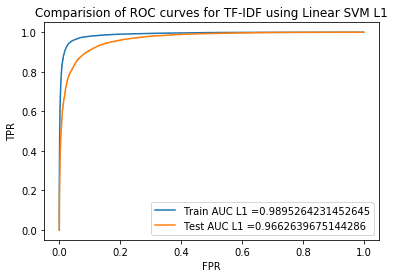

In [59]:
from sklearn.metrics import roc_curve, auc
Tr_FPR2, Tr_TPR2, tr2 = roc_curve(yTrain, Train_predict_tfidf)
Te_FPR2, Te_TPR2, te2 = roc_curve(yTest, predict_tfidf_prob)

plt.plot(Tr_FPR2, Tr_TPR2, label="Train AUC L1 ="+str(auc(Tr_FPR2, Tr_TPR2)))
plt.plot(Te_FPR2, Te_TPR2, label="Test AUC L1 ="+str(auc(Te_FPR2, Te_TPR2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for TF-IDF using Linear SVM L1")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

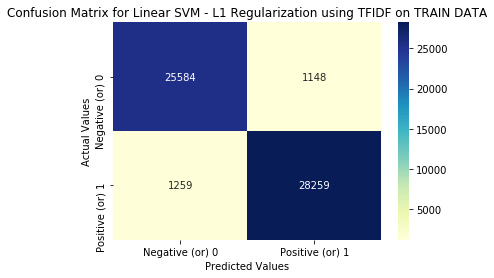

In [60]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_TFIDF)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Linear SVM - L1 Regularization using TFIDF on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

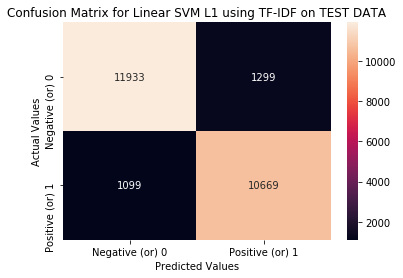

In [61]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_tfidf_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Linear SVM L1 using TF-IDF on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font> L2 Reg

In [62]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
AUC_tfidf_Train = []
AUC_tfidf_CV = []

#Linear SVM with L2 regularization on alpha values
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l2', alpha = i, class_weight = 'balanced')
    clf.fit(xTrain_tfidf, yTrain)
    calib_l4 = CalibratedClassifierCV(clf, method="sigmoid")
    calib_l4.fit(xTrain_tfidf, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value
    Y_train_pred2 =  calib_l4.predict_proba(xTrain_tfidf)[:,1]
    Y_cv_pred2 =  calib_l4.predict_proba(xCV_tfidf)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data
    AUC_tfidf_Train.append(roc_auc_score(yTrain,Y_train_pred2))
    AUC_tfidf_CV.append(roc_auc_score(yCV, Y_cv_pred2))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.23s/it]


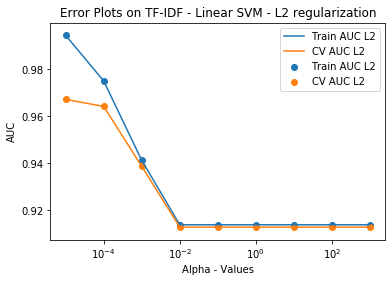

In [63]:
plt.plot(alpha_values, AUC_tfidf_Train, label='Train AUC L2')
plt.plot(alpha_values, AUC_tfidf_CV, label='CV AUC L2')

plt.scatter(alpha_values, AUC_tfidf_Train, label='Train AUC L2')
plt.scatter(alpha_values, AUC_tfidf_CV, label='CV AUC L2')
plt.xscale('log')

plt.legend()
plt.xlabel("Alpha - Values")
plt.ylabel("AUC")
plt.title("Error Plots on TF-IDF - Linear SVM - L2 regularization")
plt.show()

In [64]:
#Linear SVM on test data with optimal alpha = 0.0001
optimal_l2_tf = SGDClassifier(loss = "hinge", penalty='l2', alpha = 0.0001, class_weight = 'balanced')
optimal_l2_tf.fit(xTrain_tfidf, yTrain)
calib_tf2 = CalibratedClassifierCV(optimal_l2_tf, method="sigmoid")
calib_tf2.fit(xTrain_tfidf, yTrain)
predict_tfidf_prob = calib_tf2.predict_proba(xTest_tfidf)[:,1]
Train_predict_tfidf = calib_tf2.predict_proba(xTrain_tfidf)[:,1]
predict_tfidf_class = calib_tf2.predict(xTest_tfidf)
predict_testdata_TFIDF2 = calib_tf2.predict(xTrain_tfidf)


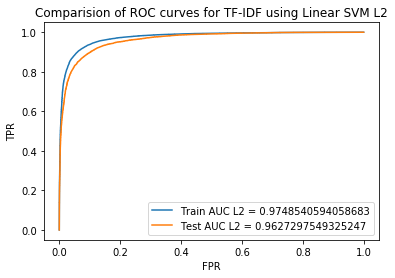

In [65]:
from sklearn.metrics import roc_curve, auc
Tr_FPR2, Tr_TPR2, tr2 = roc_curve(yTrain, Train_predict_tfidf)
Te_FPR2, Te_TPR2, te2 = roc_curve(yTest, predict_tfidf_prob)

plt.plot(Tr_FPR2, Tr_TPR2, label="Train AUC L2 = "+str(auc(Tr_FPR2, Tr_TPR2)))
plt.plot(Te_FPR2, Te_TPR2, label="Test AUC L2 = "+str(auc(Te_FPR2, Te_TPR2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for TF-IDF using Linear SVM L2")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

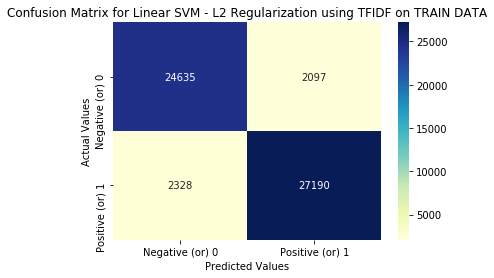

In [66]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_TFIDF2)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Linear SVM - L2 Regularization using TFIDF on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

Text(32.99999999999999, 0.5, 'Actual Values')

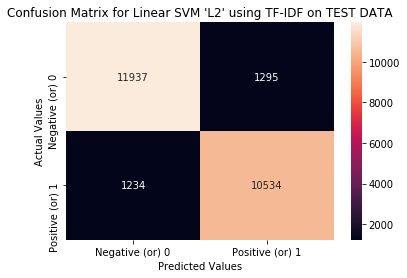

In [67]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_tfidf_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Linear SVM 'L2' using TF-IDF on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

###  Feature Importance on TFIDF,<font color='red'> SET 2</font>

### Top 10 important features from<font color='red'> SET 2</font>



In [68]:
#Source https://www.programcreek.com/python/example/81062/sklearn.datasets.load_iris
#Calculating the weight vector for the classifier
weights_tfidf = optimal_l2_tf.coef_

#Pairing the weights and features
wght_ftr_pair = dict()
feature_names = count_vect.get_feature_names()
for weight, feature in zip(weights_tfidf[0], feature_names):
    wght_ftr_pair[weight] = feature

#Printing top features
print("Top 10 positive features")
print()
positive = sorted(zip(weights_tfidf[0], feature_names))
print(positive[-10:])
print()
print('_'*100)
print()
print("Top 10 negative features")
print()
negative = sorted(zip(weights_tfidf[0], feature_names))
print(negative[:10])


Top 10 positive features

[(3.152845564307442, 'helpful'), (3.3627500570764157, 'raccoloto'), (3.4510642078432445, 'cortisone'), (3.6584698255833223, 'gaetanos'), (3.659627277047552, 'geena'), (3.713741001500987, 'joray'), (4.2775302480846795, 'doling'), (4.796767440478835, 'chinamart'), (4.800613469426818, 'assailed'), (6.320115471961282, 'duplicating')]

____________________________________________________________________________________________________

Top 10 negative features

[(-5.006452067186123, 'hoefschroer'), (-4.4414131184327665, 'citric'), (-3.4882719379414473, 'ramiel'), (-3.4659096499002127, 'house'), (-3.303239498134911, 'clamor'), (-3.2023756883261205, 'parred'), (-3.1597694233185547, 'popconopolis'), (-3.1596666132702467, 'annalise'), (-3.0404102116030827, 'imbalance'), (-2.780217918654128, 'peg')]


## Logistic Regression on AVG W2V<font color='red'> SET 3</font>


In [69]:
# Train your own Word2Vec model using your own text corpus
#-------------------TRAIN DATA----------------#
i=0
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
    
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14904
sample words  ['twist', 'captured', 'film', 'michael', 'keaton', 'geena', 'davis', 'prime', 'tim', 'burton', 'masterpiece', 'wonderfully', 'point', 'not', 'dull', 'moment', 'one', 'movie', 'collection', 'filled', 'comedy', 'action', 'whatever', 'else', 'want', 'call', 'always', 'enjoyed', 'funny', 'entertaining', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something', 'eliminated', 'strong', 'elements', 'usually', 'edited', 'television', 'version', 'warned', 'avoid', 'bought', 'apartment']


In [70]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 56250/56250 [03:06<00:00, 301.93it/s]


56250
50


In [71]:
# Train your own Word2Vec model using your own text corpus
#-------------------CROSS-VALIDATION DATA----------------#
i=0
list_of_sentance_cv=[]
for sentance in xCV:
    list_of_sentance_cv.append(sentance.split())
    

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 18750/18750 [01:07<00:00, 279.39it/s]


18750
50


In [72]:
# Train your own Word2Vec model using your own text corpus
#-------------------TEST DATA----------------#
i=0
list_of_sentance_test=[]
for sentance in xTest:
    list_of_sentance_test.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:49<00:00, 228.51it/s]


25000
50


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font> L1 Reg


In [77]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1]
AUC_aw2v_Train = []
AUC_aw2v_CV = []

#Linear SVM with L1 regularization on alpha values
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l1', alpha = i, class_weight = 'balanced')
    clf.fit(sent_vectors_train, yTrain)
    calib_l5 = CalibratedClassifierCV(clf, method="sigmoid")
    calib_l5.fit(sent_vectors_train, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value    
    Y_train_pred3 =  calib_l5.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred3 =  calib_l5.predict_proba(sent_vectors_cv)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data    
    AUC_aw2v_Train.append(roc_auc_score(yTrain,Y_train_pred3))
    AUC_aw2v_CV.append(roc_auc_score(yCV, Y_cv_pred3))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]


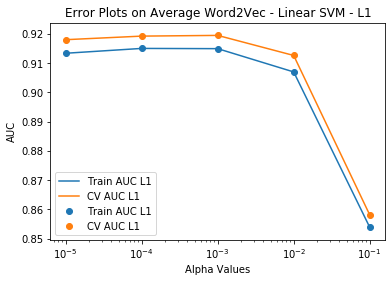

In [78]:
plt.plot(alpha_values, AUC_aw2v_Train, label='Train AUC L1')
plt.plot(alpha_values, AUC_aw2v_CV, label='CV AUC L1')

plt.scatter(alpha_values, AUC_aw2v_Train, label='Train AUC L1')
plt.scatter(alpha_values, AUC_aw2v_CV, label='CV AUC L1')
plt.xscale('log')

plt.legend()
plt.xlabel("Alpha Values")
plt.ylabel("AUC")
plt.title("Error Plots on Average Word2Vec - Linear SVM - L1")
plt.show()

In [81]:
#Linear SVM on test data with optimal alpha = 0.01
optimal_l1_w2v = SGDClassifier(loss = "hinge", penalty='l1', alpha = 0.01, class_weight = 'balanced')
optimal_l1_w2v.fit(sent_vectors_train, yTrain)
calib_w2v1 = CalibratedClassifierCV(optimal_l1_w2v, method="sigmoid")
calib_w2v1.fit(sent_vectors_train, yTrain)
Train_predict_aw2v = calib_w2v1.predict_proba(sent_vectors_train)[:,1]
predict_aw2v_prob = calib_w2v1.predict_proba(sent_vectors_test)[:,1]
predict_aw2v_class = calib_w2v1.predict(sent_vectors_test)
predict_testdata_W2V = calib_w2v1.predict(sent_vectors_train)

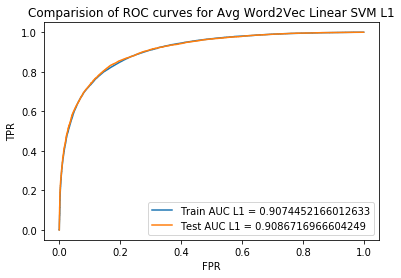

In [82]:
Tr_FPR3, Tr_TPR3, tr3 = roc_curve(yTrain, Train_predict_aw2v)
Te_FPR3, Te_TPR3, te3 = roc_curve(yTest, predict_aw2v_prob)

plt.plot(Tr_FPR3, Tr_TPR3, label="Train AUC L1 = "+str(auc(Tr_FPR3, Tr_TPR3)))
plt.plot(Te_FPR3, Te_TPR3, label="Test AUC L1 = "+str(auc(Te_FPR3, Te_TPR3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for Avg Word2Vec Linear SVM L1")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

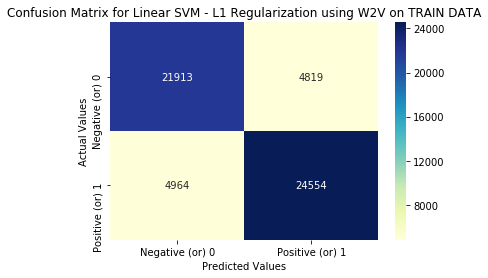

In [83]:

# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_W2V)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Linear SVM - L1 Regularization using W2V on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

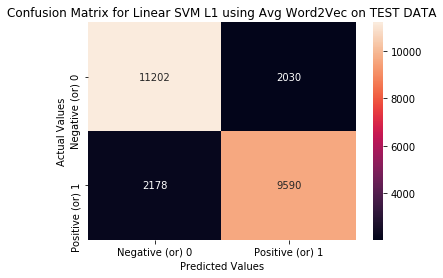

In [84]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_aw2v_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Linear SVM L1 using Avg Word2Vec on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

### Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [86]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
AUC_aw2v_Train = []
AUC_aw2v_CV = []

#Linear SVM with L2 regularization on alpha values
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l2', alpha = i, class_weight = 'balanced')
    clf.fit(sent_vectors_train, yTrain)
    calib_l6 = CalibratedClassifierCV(clf, method="sigmoid")
    calib_l6.fit(sent_vectors_train, yTrain)
      
    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value    
    Y_train_pred3 =  calib_l6.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred3 =  calib_l6.predict_proba(sent_vectors_cv)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data    
    AUC_aw2v_Train.append(roc_auc_score(yTrain,Y_train_pred3))
    AUC_aw2v_CV.append(roc_auc_score(yCV, Y_cv_pred3))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.11s/it]


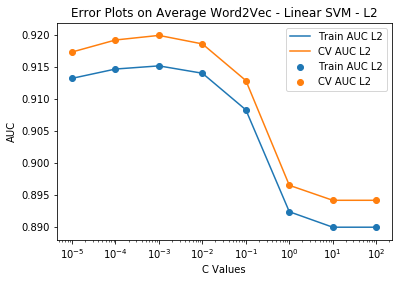

In [87]:
plt.plot(alpha_values, AUC_aw2v_Train, label='Train AUC L2')
plt.plot(alpha_values, AUC_aw2v_CV, label='CV AUC L2')

plt.scatter(alpha_values, AUC_aw2v_Train, label='Train AUC L2')
plt.scatter(alpha_values, AUC_aw2v_CV, label='CV AUC L2')
plt.xscale('log')

plt.legend()
plt.xlabel("C Values")
plt.ylabel("AUC")
plt.title("Error Plots on Average Word2Vec - Linear SVM - L2")
plt.show()

In [88]:
#Linear SVM on test data with optimal alpha = 0.01
optimal_l1_w2v = SGDClassifier(loss = "hinge", penalty='l2', alpha = 0.01, class_weight = 'balanced')
optimal_l1_w2v.fit(sent_vectors_train, yTrain)
calib_w2v2 = CalibratedClassifierCV(optimal_l1_w2v, method="sigmoid")
calib_w2v2.fit(sent_vectors_train, yTrain)
Train_predict_aw2v = calib_w2v2.predict_proba(sent_vectors_train)[:,1]
predict_aw2v_prob = calib_w2v2.predict_proba(sent_vectors_test)[:,1]
predict_aw2v_class = calib_w2v2.predict(sent_vectors_test)
predict_testdata_W2v2 = calib_w2v2.predict(sent_vectors_train)


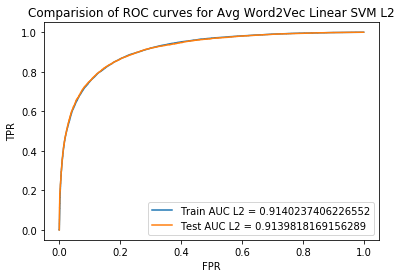

In [89]:
Tr_FPR3, Tr_TPR3, tr3 = roc_curve(yTrain, Train_predict_aw2v)
Te_FPR3, Te_TPR3, te3 = roc_curve(yTest, predict_aw2v_prob)

plt.plot(Tr_FPR3, Tr_TPR3, label="Train AUC L2 = "+str(auc(Tr_FPR3, Tr_TPR3)))
plt.plot(Te_FPR3, Te_TPR3, label="Test AUC L2 = "+str(auc(Te_FPR3, Te_TPR3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for Avg Word2Vec Linear SVM L2")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

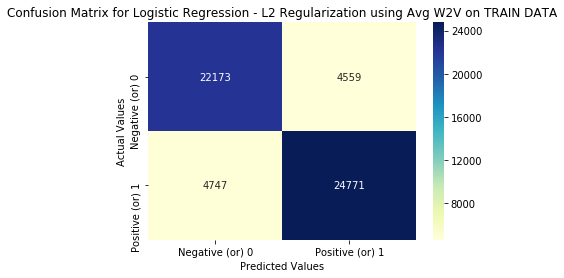

In [90]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_W2v2)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Logistic Regression - L2 Regularization using Avg W2V on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

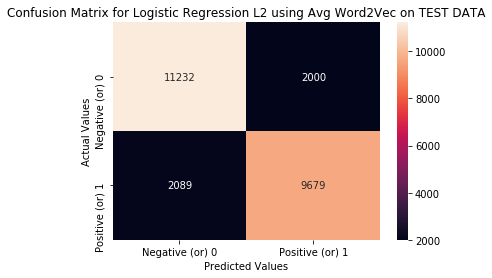

In [91]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_aw2v_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Logistic Regression L2 using Avg Word2Vec on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

##  Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(xTrain)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [93]:
#------------------------TF-IDF Word2Vec----------------
#-------------------------TRAIN DATA--------------------
i=0
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
    
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# XXfinal_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56250/56250 [38:40<00:00, 24.24it/s]


In [94]:
#------------------------TF-IDF Word2Vec----------------
#---------------------CROSS VALIDATION DATA--------------------
i=0
list_of_sentance_cv=[]
for sentance in xCV:
    list_of_sentance_cv.append(sentance.split())
    
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# XXfinal_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18750/18750 [14:16<00:00, 21.88it/s]


In [95]:
#------------------------TF-IDF Word2Vec----------------
#-------------------------Test DATA--------------------
i=0
list_of_sentance_test=[]
for sentance in xTest:
    list_of_sentance_test.append(sentance.split())
    
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# XXfinal_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [37:14<00:00, 11.19it/s]


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font> L1

In [96]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
AUC_tfidfw2v_Train = []
AUC_tfidfw2v_CV = []

#Linear SVM with L1 regularization on alpha values
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l1', alpha = i, class_weight = 'balanced')
    clf.fit(tfidf_sent_vectors_train, yTrain)
    calib_l7 = CalibratedClassifierCV(clf, method="sigmoid")
    calib_l7.fit(tfidf_sent_vectors_train, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value    
    Y_train_pred4 =  calib_l7.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred4 =  calib_l7.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data    
    AUC_tfidfw2v_Train.append(roc_auc_score(yTrain,Y_train_pred4))
    AUC_tfidfw2v_CV.append(roc_auc_score(yCV, Y_cv_pred4))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:50<00:00,  5.08s/it]


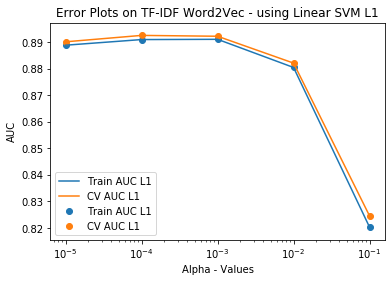

In [100]:
plt.plot(alpha_values[:5], AUC_tfidfw2v_Train[:5], label='Train AUC L1')
plt.plot(alpha_values[:5], AUC_tfidfw2v_CV[:5], label='CV AUC L1')

plt.scatter(alpha_values[:5], AUC_tfidfw2v_Train[:5], label='Train AUC L1')
plt.scatter(alpha_values[:5], AUC_tfidfw2v_CV[:5], label='CV AUC L1')
plt.xscale('log')

plt.legend()
plt.xlabel("Alpha - Values")
plt.ylabel("AUC")
plt.title("Error Plots on TF-IDF Word2Vec - using Linear SVM L1")
plt.show()

In [101]:
#Linear SVM on test data with optimal alpha = 0.001
optimal_l1_at = SGDClassifier(loss = "hinge", penalty='l1', alpha = 0.001, class_weight = 'balanced')
optimal_l1_at.fit(tfidf_sent_vectors_train, yTrain)
calib_at1 = CalibratedClassifierCV(optimal_l1_at, method="sigmoid")
calib_at1.fit(tfidf_sent_vectors_train, yTrain)
Train_predict_tfidfw2v = calib_at1.predict_proba(tfidf_sent_vectors_train)[:,1]
predict_tfidfw2v_prob = calib_at1.predict_proba(tfidf_sent_vectors_test)[:,1]
predict_tfidfw2v_class = calib_at1.predict(tfidf_sent_vectors_test)
predict_testdata_at = calib_at1.predict(tfidf_sent_vectors_train)

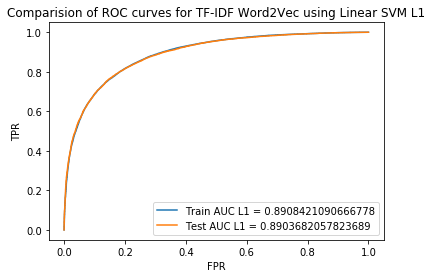

In [102]:
Tr_FPR4, Tr_TPR4, tr4 = roc_curve(yTrain, Train_predict_tfidfw2v)
Te_FPR4, Te_TPR4, te4 = roc_curve(yTest, predict_tfidfw2v_prob)

plt.plot(Tr_FPR4, Tr_TPR4, label="Train AUC L1 = "+str(auc(Tr_FPR4, Tr_TPR4)))
plt.plot(Te_FPR4, Te_TPR4, label="Test AUC L1 = "+str(auc(Te_FPR4, Te_TPR4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for TF-IDF Word2Vec using Linear SVM L1")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

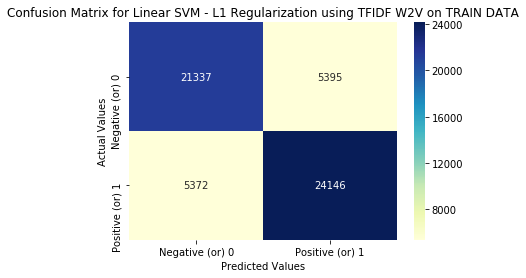

In [103]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_at)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Linear SVM - L1 Regularization using TFIDF W2V on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

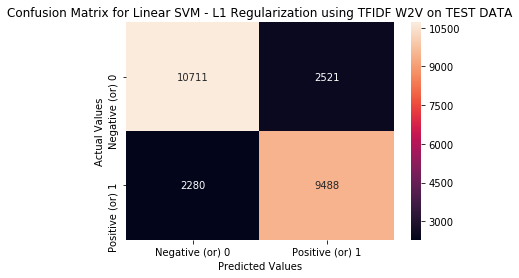

In [104]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_tfidfw2v_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Linear SVM - L1 Regularization using TFIDF W2V on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

### Applying Linear SVM with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [105]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
AUC_tfidfw2v_Train = []
AUC_tfidfw2v_CV = []

#Linear SVM Classifier with L2 regularization on alpha values
for i in tqdm(alpha_values):
    clf = SGDClassifier(loss = "hinge", penalty='l2', alpha = i, class_weight = 'balanced')
    clf.fit(tfidf_sent_vectors_train, yTrain)
    calib_l8 = CalibratedClassifierCV(clf, method="sigmoid")
    calib_l8.fit(tfidf_sent_vectors_train, yTrain)

    #Predicting probability of positive class
    #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
    #we are slicing 2nd value    
    Y_train_pred4 =  calib_l8.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred4 =  calib_l8.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    #Calculation of ROC-AUC score on both train and-cross validate data    
    AUC_tfidfw2v_Train.append(roc_auc_score(yTrain,Y_train_pred4))
    AUC_tfidfw2v_CV.append(roc_auc_score(yCV, Y_cv_pred4))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.15s/it]


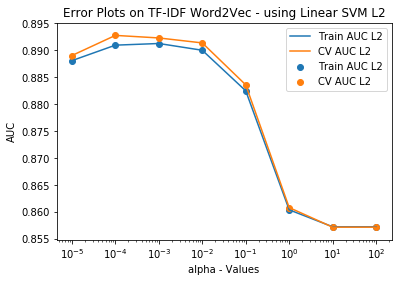

In [106]:
plt.plot(alpha_values, AUC_tfidfw2v_Train, label='Train AUC L2')
plt.plot(alpha_values, AUC_tfidfw2v_CV, label='CV AUC L2')

plt.scatter(alpha_values, AUC_tfidfw2v_Train, label='Train AUC L2')
plt.scatter(alpha_values, AUC_tfidfw2v_CV, label='CV AUC L2')
plt.xscale('log')

plt.legend()
plt.xlabel("alpha - Values")
plt.ylabel("AUC")
plt.title("Error Plots on TF-IDF Word2Vec - using Linear SVM L2")
plt.show()

In [110]:
#Linear SVM on test data with optimal alpha = 0.01
optimal_l2_at = SGDClassifier(loss = "hinge", penalty='l2', alpha = 0.01, class_weight = 'balanced')
optimal_l2_at.fit(tfidf_sent_vectors_train, yTrain)
calib_at2 = CalibratedClassifierCV(optimal_l2_at, method="sigmoid")
calib_at2.fit(tfidf_sent_vectors_train, yTrain)
Train_predict_tfidfw2v = calib_at2.predict_proba(tfidf_sent_vectors_train)[:,1]
predict_tfidfw2v_prob = calib_at2.predict_proba(tfidf_sent_vectors_test)[:,1]
predict_tfidfw2v_class = calib_at2.predict(tfidf_sent_vectors_test)
predict_testdata_at2 = calib_at2.predict(tfidf_sent_vectors_train)


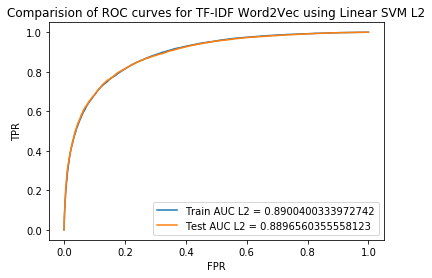

In [111]:
Tr_FPR4, Tr_TPR4, tr4 = roc_curve(yTrain, Train_predict_tfidfw2v)
Te_FPR4, Te_TPR4, te4 = roc_curve(yTest, predict_tfidfw2v_prob)

plt.plot(Tr_FPR4, Tr_TPR4, label="Train AUC L2 = "+str(auc(Tr_FPR4, Tr_TPR4)))
plt.plot(Te_FPR4, Te_TPR4, label="Test AUC L2 = "+str(auc(Te_FPR4, Te_TPR4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for TF-IDF Word2Vec using Linear SVM L2")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

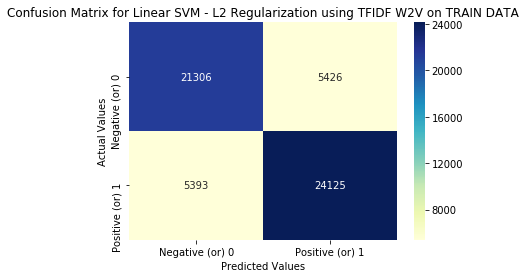

In [112]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_at2)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Linear SVM - L2 Regularization using TFIDF W2V on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

Text(32.99999999999999, 0.5, 'Actual Values')

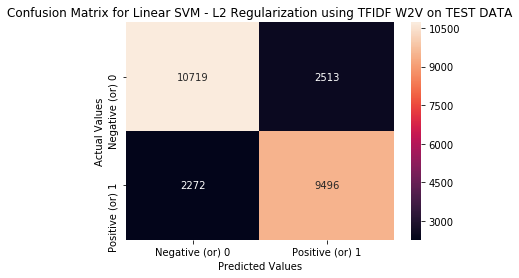

In [113]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_tfidfw2v_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Linear SVM - L2 Regularization using TFIDF W2V on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# Conclusion

In [114]:
from prettytable import PrettyTable    
x = PrettyTable()

x.field_names = ["Vectorizer", "Regularization", "Optimal Alpha", "Test AUC"]

x.add_row(["Bag of Words", "L1", 0.0001, 0.93])
x.add_row(["Bag of Words", "L2", 0.001, 0.94])
x.add_row(["TF-IDF", "L1", 0.00001, 0.96])
x.add_row(["TF-IDF", "L2", 0.0001, 0.96])
x.add_row(["Avg W2V", "L1", 0.01, 0.90])
x.add_row(["Avg W2V", "L2", 0.01, 0.91])
x.add_row(["TF-IDF W2V", "L1", 0.001, 0.89])
x.add_row(["TF-IDF W2V", "L2", 0.01, 0.88])

print(x)

+--------------+----------------+---------------+----------+
|  Vectorizer  | Regularization | Optimal Alpha | Test AUC |
+--------------+----------------+---------------+----------+
| Bag of Words |       L1       |     0.0001    |   0.93   |
| Bag of Words |       L2       |     0.001     |   0.94   |
|    TF-IDF    |       L1       |     1e-05     |   0.96   |
|    TF-IDF    |       L2       |     0.0001    |   0.96   |
|   Avg W2V    |       L1       |      0.01     |   0.9    |
|   Avg W2V    |       L2       |      0.01     |   0.91   |
|  TF-IDF W2V  |       L1       |     0.001     |   0.89   |
|  TF-IDF W2V  |       L2       |      0.01     |   0.88   |
+--------------+----------------+---------------+----------+
